# Mercari Price Prediction Exploratory Data Analysis (EDA)

### This is an initial Explanatory Data Analysis for the Mercari Price Suggestion Challenge with matplotlib. The competition is hosted by Mercari, the biggest Japanese community-powered shopping app with the main objective to predict an accurate price that Mercari should suggest to its sellers, given the item's information.

### Below we will start by importing the necessary libraries at Python's disposal to perform some visual and detailed analysis of the data before moving onto the machine learning portion of the project:

In [85]:
import scipy as sp
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import squarify
#Term frequency vectorizer
from sklearn.model_selection import train_test_split
import re
import xgboost

## Initial Look:

#### Here we will look at the data overview, tables, and some simple graphs of the target variable and transformations before we delve into each individual category and its relation to the target variable (price).

In [2]:
train = pd.read_csv("train.tsv", sep='\t', header=0)
train.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity


#### Already the data appears to have some numerical values, but also has string based features that we will have to transform. The price feature will be our target variable.

In [3]:
test = pd.read_csv("test.tsv", sep='\t', header=0)
test.head()

,test_id,name,item_condition_id,category_name,brand_name,shipping,item_description
0,0,"Breast cancer ""I fight like a girl"" ring",1,Women/Jewelry/Rings,NaN,1,Size 7
1,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers",1,Other/Office supplies/Shipping Supplies,NaN,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers Lined..."
2,2,Coach bag,1,Vintage & Collectibles/Bags and Purses/Handbag,Coach,1,Brand new coach bag. Bought for [rm] at a Coac...
3,3,Floral Kimono,2,Women/Sweaters/Cardigan,NaN,0,-floral kimono -never worn -lightweight and pe...
4,4,Life after Death,3,Other/Books/Religion & Spirituality,NaN,1,Rediscovering life after the loss of a loved o...


In [4]:
train.describe()

,train_id,item_condition_id,price,shipping
count,1.482535e+06,1.482535e+06,1.482535e+06,1.482535e+06
mean,7.412670e+05,1.907380e+00,2.673752e+01,4.472744e-01
std,4.279711e+05,9.031586e-01,3.858607e+01,4.972124e-01
min,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
25%,3.706335e+05,1.000000e+00,1.000000e+01,0.000000e+00
50%,7.412670e+05,2.000000e+00,1.700000e+01,0.000000e+00
75%,1.111900e+06,3.000000e+00,2.900000e+01,1.000000e+00
max,1.482534e+06,5.000000e+00,2.009000e+03,1.000000e+00


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1482535 entries, 0 to 1482534
Data columns (total 8 columns):
train_id             1482535 non-null int64
name                 1482535 non-null object
item_condition_id    1482535 non-null int64
category_name        1476208 non-null object
brand_name           849853 non-null object
price                1482535 non-null float64
shipping             1482535 non-null int64
item_description     1482531 non-null object
dtypes: float64(1), int64(3), object(4)
memory usage: 90.5+ MB


In [6]:
train.shape

(1482535, 8)

In [7]:
train.dtypes

train_id               int64
name                  object
item_condition_id      int64
category_name         object
brand_name            object
price                float64
shipping               int64
item_description      object
dtype: object

In [8]:
train.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity


#### We have a couple of string based features (*name*, *category_name*, *brand_name*, and *item_description*) that can later be used to combine or separate into a text classification using term frequency vectorization. Stop words will have to be removed for the analysis to work and top features will have to be gleaned from the data.

#### *item_condition_id* and *shipping* could potentially be used as binary values that further help reach accurate price predictions.


#### We will be combining the train and test sets to conduct data cleaning measures at equal rate. A mask with train_rows will be created to separate the data to their respective train and test sets after data cleaning is completed.

In [9]:
# remove rows with empty descriptions
train = train[~train['item_description'].isnull()]
test = test[~test['item_description'].isnull()]

data = pd.concat([train, test], 0)
train_rows = train.shape[0]
print(train_rows)

1482531


In [10]:
train.item_description

0                                         No description yet
1          This keyboard is in great condition and works ...
2          Adorable top with a hint of lace and a key hol...
3          New with tags. Leather horses. Retail for [rm]...
4                  Complete with certificate of authenticity
5          Banana republic bottoms, Candies skirt with ma...
6          Size small but straps slightly shortened to fi...
7          You get three pairs of Sophie cheer shorts siz...
8           Girls Size small Plus green. Three shorts total.
9          I realized his pants are on backwards after th...
10              0.25 oz Full size is 1oz for [rm] in Sephora
11         (5) new vs pink body mists (2.5 oz each) Fresh...
12                                       Xl, great condition
13                                        No description yet
14         Authentic. Suede fringe boots. Great condition...
15         Brand new. Deluxe travel size products. Contai...
16         2 glitter eye

#### The item_description section will need to be cleaed up as there are a lot of punctuations, symbols (✨), and capital letters that would otherwise interfere with the learning algorithms.

## I. Initial Look (Target Variable): Price graphs

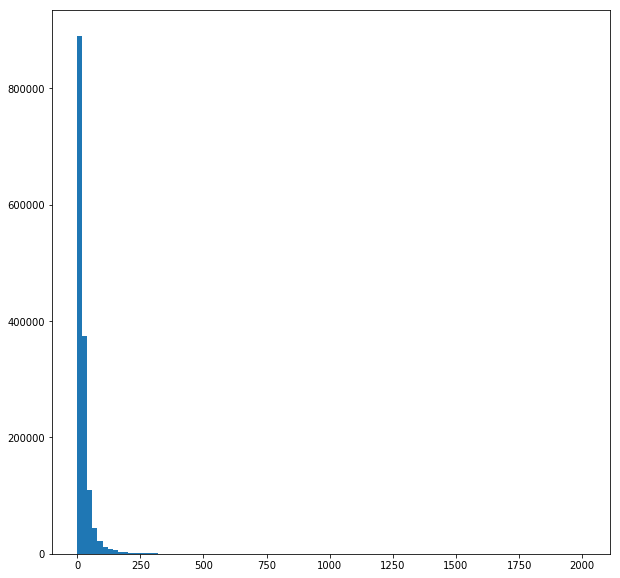

In [11]:
plt.figure(figsize=(10,10))
plt.hist(train['price'], bins = 100)
plt.show()

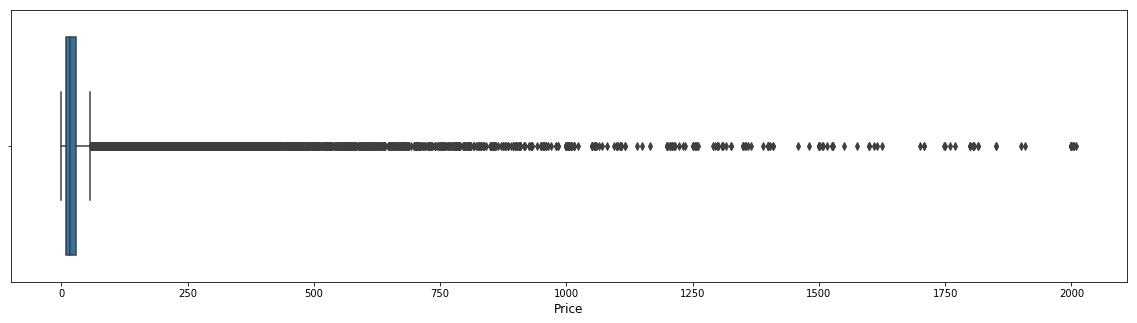

In [12]:
plt.figure(figsize= (20,5)) 
sns.boxplot(train.price)
plt.xlabel("Price", fontsize='large')
plt.show()

#### Our target variable is definitely exponentially distributed and skewed to the right. We will have to take a log of this feature as a response to this skew. The average price is $26.73. Let's see what taking the log does to the price variable:

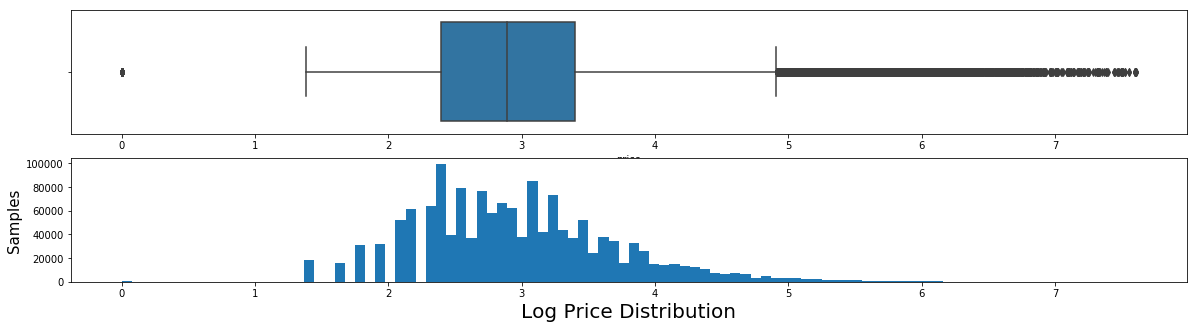

In [26]:
train['log_price'] = np.log(train.price + 1)
fig, ax = plt.subplots(2, 1, figsize = (20, 5))
sns.boxplot(train.log_price, ax = ax[0])
ax[1].hist(train.log_price, bins = 100)
#ax[1].set_title("Log Price Distribution", fontsize = 20)
ax[1].set_xlabel("Log Price Distribution", fontsize = 20)
ax[1].set_ylabel("Samples", fontsize = 15)
plt.show()

In [14]:
print("*Regular Price*:\n\n", train.price.describe(),"\n")
print("*Log Price*:\n\n",train.log_price.describe())

*Regular Price*:

 count    1.482531e+06
mean     2.673754e+01
std      3.858611e+01
min      0.000000e+00
25%      1.000000e+01
50%      1.700000e+01
75%      2.900000e+01
max      2.009000e+03
Name: price, dtype: float64 

*Log Price*:

 count    1.482531e+06
mean     2.979060e+00
std      7.492094e-01
min      0.000000e+00
25%      2.397895e+00
50%      2.890372e+00
75%      3.401197e+00
max      7.605890e+00
Name: price, dtype: float64


#### Taking the log (+1 to avoid 0 or negative values) has allowed the target variable to assume a more Gaussian distribution which will be more optimal for modeling. 

####  Median Log Price comes out to 2.890472e+00, while mean is close by at 2.979060e+00

## II. Shipping

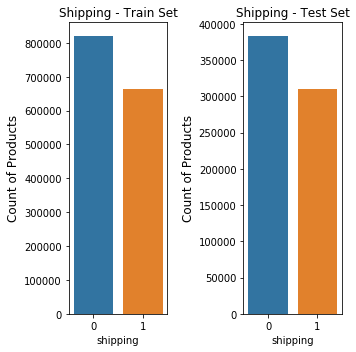

In [29]:
_ = plt.figure(figsize=(5,5))
_ = plt.subplot(1,2,1)
_ = sns.countplot(train['shipping'])
_ = plt.ylabel("Count of Products", fontsize='large')
_ = plt.title('Shipping - Train Set')


_ = plt.subplot(1,2,2)
_ = sns.countplot(test['shipping'])
_ = plt.ylabel("Count of Products", fontsize='large')
_ = plt.title('Shipping - Test Set')

plt.tight_layout()
plt.show()

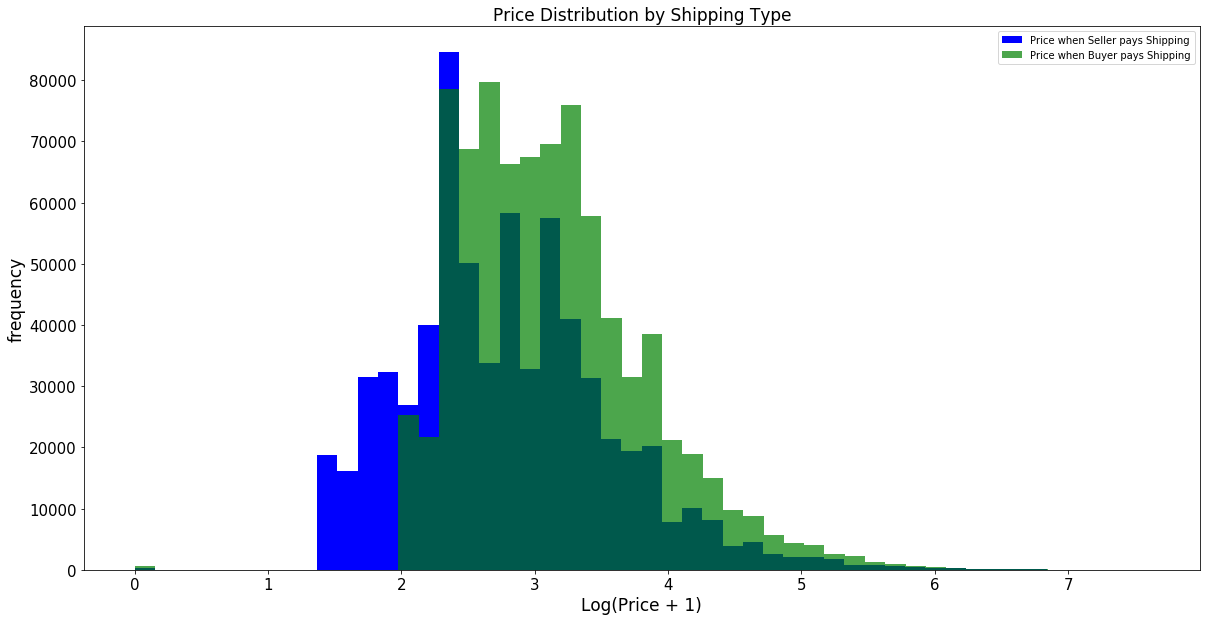

In [19]:
shipping_seller_price = train.loc[train.shipping==1, 'price']
shipping_buyer_price = train.loc[train.shipping==0, 'price']

fig, ax = plt.subplots(figsize=(20,10))
ax.hist(np.log(shipping_seller_price+1), color='blue', alpha=1.0, bins=50,
       label='Price when Seller pays Shipping')
ax.hist(np.log(shipping_buyer_price+1), color='green', alpha=0.7, bins=50,
       label='Price when Buyer pays Shipping')
ax.set(title='Histogram Comparison', ylabel='% of Dataset in Bin')
plt.xlabel('Log(Price + 1)', fontsize=17)
plt.ylabel('frequency', fontsize=17)
plt.title('Price Distribution by Shipping Type', fontsize=17)
plt.legend()
plt.tick_params(labelsize=15)

plt.show()



#### Semi expected as the target price variable is higher for when the customer (buyer) covers shipping vs when the seller pays/ covers shipping. The inflated price value for when the customer covers shipping costs makes sense.

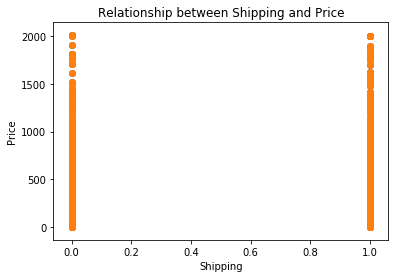

In [21]:
plt.scatter(train.shipping, train.price)
plt.xlabel("Shipping")
plt.ylabel("Price")
plt.title("Relationship between Shipping and Price")
plt.show()

In [27]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
m = ols('log_price ~ shipping',train).fit()
print(m.summary())

                            OLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       0.053
Model:                            OLS   Adj. R-squared:                  0.053
Method:                 Least Squares   F-statistic:                 8.261e+04
Date:                Fri, 30 Mar 2018   Prob (F-statistic):               0.00
Time:                        11:37:09   Log-Likelihood:            -1.6354e+06
No. Observations:             1482531   AIC:                         3.271e+06
Df Residuals:                 1482529   BIC:                         3.271e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.1339      0.001   3890.558      0.0

#### The p-value for the shipping prices are lower than 0.05, which means that the shipping feature is statistically significant to determining price. This means that regression using only shipping does not explain much of the variation in the data but it is significant. The low $R^{2}$ would mean that shipping is a nice to have feature, but could be taken out. 

## III. Categories

In [30]:
train['category_name'].head()

0                                    Men/Tops/T-shirts
1    Electronics/Computers & Tablets/Components & P...
2                          Women/Tops & Blouses/Blouse
3                   Home/Home Décor/Home Décor Accents
4                              Women/Jewelry/Necklaces
Name: category_name, dtype: object

In [31]:
print('unique categories: ', train['category_name'].nunique())
print('unique products: ', train['name'].nunique())

unique categories:  1287
unique products:  1225270


#### There are 1,287 unique categories and 1,214,053 products within those cateogires. These labels will be able to help determine what price each product will be. Let us look at some stats on these categories in more detail:

In [32]:
print('Top Ten Categories:')
train['category_name'].value_counts()[:10]

Top Ten Categories:


Women/Athletic Apparel/Pants, Tights, Leggings                 60177
Women/Tops & Blouses/T-Shirts                                  46380
Beauty/Makeup/Face                                             34335
Beauty/Makeup/Lips                                             29909
Electronics/Video Games & Consoles/Games                       26557
Beauty/Makeup/Eyes                                             25215
Electronics/Cell Phones & Accessories/Cases, Covers & Skins    24676
Women/Underwear/Bras                                           21274
Women/Tops & Blouses/Tank, Cami                                20284
Women/Tops & Blouses/Blouse                                    20284
Name: category_name, dtype: int64

#### Womens, Beauty, and Electronics come at the top ten frequency of products for raw categories. The dataset provide valuable information about the primary kinds of customer community that Mercari may most likely have. There is not gender designation or order details, but there seems to be a large frequency of Women's beauty products and clothing. Let us see the price breakdowns of products:

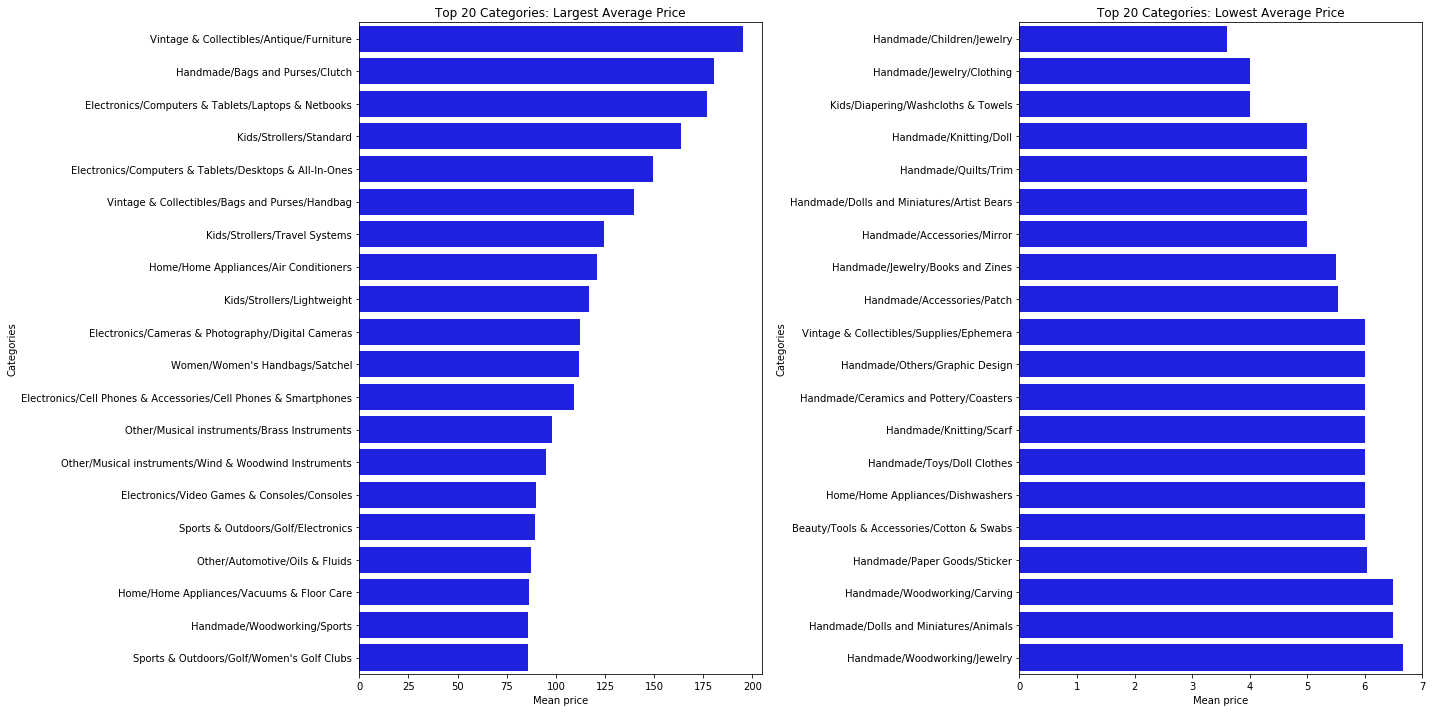

In [33]:
categories = train.groupby(train.category_name)
price = pd.DataFrame(categories['price'].mean())
high_price = price.sort_values(by='price', ascending = False).head(20)
high_price.reset_index(level=0, inplace=True)
low_price = price.sort_values(by='price', ascending = True).head(20)
low_price.reset_index(level=0, inplace=True)

plt.figure(figsize=(20,10))
_ = plt.subplot(1,2,1)
_ = sns.barplot(x = 'price', y = 'category_name', data = high_price, orient = 'h', color = 'b')
_ = plt.title('Top 20 Categories: Largest Average Price')
_ = plt.ylabel('Categories')
_ = plt.xlabel('Mean price')


_ = plt.subplot(1,2,2)
_ = sns.barplot(x = 'price', y = 'category_name', data = low_price, orient = 'h', color = 'b')
_ = plt.title('Top 20 Categories: Lowest Average Price')
_ = plt.ylabel('Categories')
_ = plt.xlabel('Mean price')

plt.tight_layout()
plt.show()

#### From the graphs above, we can see that most products tend to fall within a three category breakdown for identifying departments. These may come in handy as the breakdowns might reveal factors that determine average prices within each pairing. Let's look at average prices and differences we might see in the aggregate form of these categories:

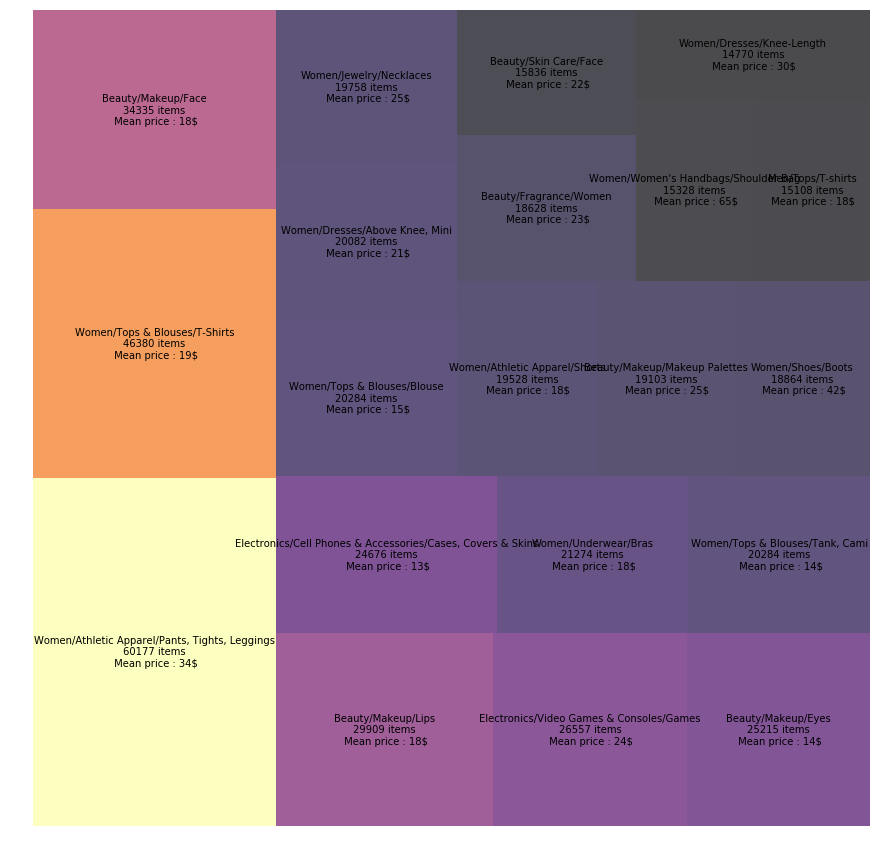

In [34]:
categories = pd.DataFrame(train.category_name.value_counts())
categories.reset_index(level = 0, inplace=True)
categories = categories.sort_values(by='category_name', ascending = False).head(20)
categories.columns =('category_name', 'size')

# Price by category
group = train.groupby(train.category_name)
mean_price = group.price.mean()
mean_price = pd.DataFrame(mean_price)
mean_price.reset_index(level = 0, inplace=True)

# Merging
categories = pd.merge(categories, mean_price, how='left', on = 'category_name')

# Colors setting
cmap = plt.cm.inferno
mini=min(categories['size'])
maxi=max(categories['size'])
norm = matplotlib.colors.Normalize(vmin=mini, vmax=maxi)
colors = [cmap(norm(value)) for value in categories['size']]

# Labels setting
labels = ["%s\n%d items\n Mean price : %d$" % (label) \
          for label in zip(categories['category_name'], categories['size'], categories['price'])]

# Plotting
plt.figure(figsize=(15,15))
plt.rc('font', size=10)
squarify.plot(sizes = categories['size'], label = labels, alpha = .7, color=colors)
plt.axis('off')
plt.show()

#### We see that the breakdown of aggregated categories can indeed be more granular. We can try to break the "category_name" field into three distinct columns, but for text based vectorization, three distinct columns with multiple combinations may not be ideal and may cause overfitting of data. For this case, we will take the primary category and secondary category for more granularity.

In [35]:
train.category_name

0                                          Men/Tops/T-shirts
1          Electronics/Computers & Tablets/Components & P...
2                                Women/Tops & Blouses/Blouse
3                         Home/Home Décor/Home Décor Accents
4                                    Women/Jewelry/Necklaces
5                                          Women/Other/Other
6                                   Women/Swimwear/Two-Piece
7                            Sports & Outdoors/Apparel/Girls
8                            Sports & Outdoors/Apparel/Girls
9                   Vintage & Collectibles/Collectibles/Doll
10                                        Beauty/Makeup/Face
11                                    Beauty/Fragrance/Women
12                            Women/Dresses/Above Knee, Mini
13                     Other/Office supplies/School Supplies
14                                         Women/Shoes/Boots
15                                 Beauty/Makeup/Makeup Sets
16                      

In [36]:
dfs = [train,test]
for i in (dfs):
    i['primary_cat'] = i.category_name.str.extract('([^/]+)/[^/]+/[^/]+')
    i['secondary_cat'] = i.category_name.str.extract('[^/]+/([^/]+/[^/]+)')

#train['primary_cat'] = i.category_name.str.extract('([^/]+)/[^/]+/[^/]+')
#train['secondary_cat'] = i.category_name.str.extract('[^/]+/([^/]+/[^/]+)')





c:\users\kj.park\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  This is separate from the ipykernel package so we can avoid doing imports until
c:\users\kj.park\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  after removing the cwd from sys.path.


In [37]:
print('unique primary categories: \n',train['primary_cat'].nunique())
print('unique secondary categories: \n',train['secondary_cat'].nunique())

unique primary categories: 
 10
unique secondary categories: 
 1198


In [38]:
train['secondary_cat']

0                                              Tops/T-shirts
1                     Computers & Tablets/Components & Parts
2                                      Tops & Blouses/Blouse
3                              Home Décor/Home Décor Accents
4                                          Jewelry/Necklaces
5                                                Other/Other
6                                         Swimwear/Two-Piece
7                                              Apparel/Girls
8                                              Apparel/Girls
9                                          Collectibles/Doll
10                                               Makeup/Face
11                                           Fragrance/Women
12                                  Dresses/Above Knee, Mini
13                           Office supplies/School Supplies
14                                               Shoes/Boots
15                                        Makeup/Makeup Sets
16                      

#### There are 10 main categories (basically like aisles), 1198 secondary categories (aisle contents). We could split this even further, but in doing so, we would most likely create an issue with dimensionality.

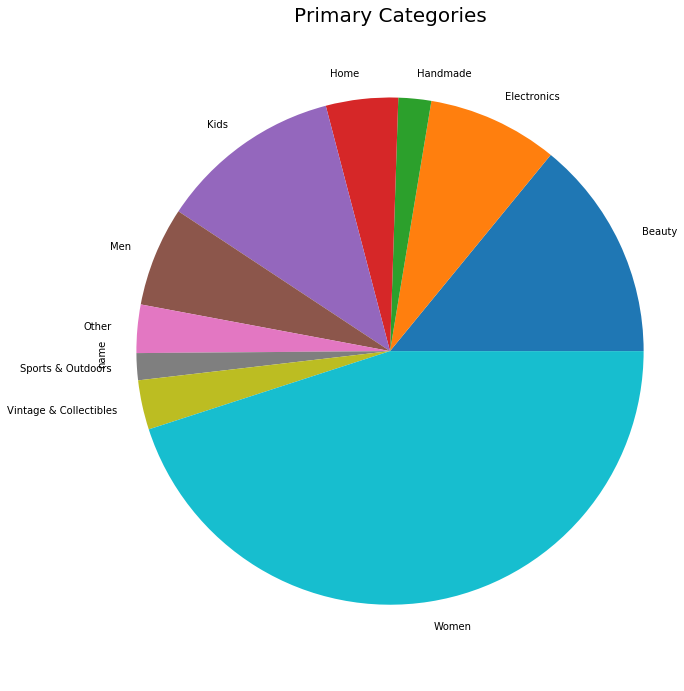

In [39]:
plt.figure(figsize = (10,12))
train.name.groupby(train.primary_cat).count().plot(kind = 'pie')
plt.title ('Primary Categories', fontsize = 20)
plt.axis('equal')
plt.show()

#### The plot below will explore the relation of log price to the primary categories:

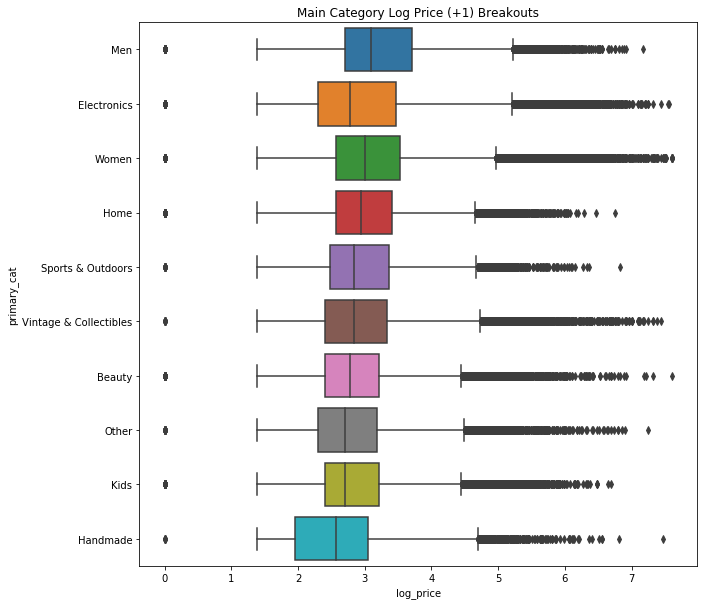

In [40]:
plt.figure(figsize = (10,10))
plt.title('Main Category Log Price (+1) Breakouts')
plt.xlabel("Log Price +1")
plt.ylabel("Primary Categories")
ax = sns.boxplot(x = 'log_price' , y ="primary_cat", data=train, orient="h")
plt.show()

#### From this point we wil be tokenizing certain features at an individual level to see if there is a case for using the categories in the machine learning algorithm. We will be checking on the individual features one by on in relation to the target price variable to determine their efficacy for future use in the machine learning algorithm. 

#### The words with be tokenized using a Lemmatizer that will remove any suffixes and any additional verbiage to create root word tokens for the feature corpus

In [79]:
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer 
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer
import nltk
nltk.download('wordnet')
class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, articles):
        return [self.wnl.lemmatize(t) for t in word_tokenize(articles)]

tfidf = TfidfVectorizer(tokenizer=LemmaTokenizer(),
                                strip_accents = 'unicode',
                                stop_words = 'english',
                                lowercase = True,
                                max_df = .9,
                                min_df = .005,
                                max_features=1000,
                                ngram_range=(1, 2))

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\kj.park\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [68]:
train = train.apply(lambda x: x.astype(str).str.lower())
text_features = ['name', 'brand_name', 'category_name', 'primary_cat', 'secondary_cat', 'item_description']
for t in text_features:
    train[t].replace(regex=True,inplace=True,to_replace=r'\W',value=r' ')
    
primary_cat = train['primary_cat'].values
secondary_cat = train['secondary_cat'].values


In [54]:
primary_cat = tfidf.fit_transform(primary_cat)

In [60]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(primary_cat, train.log_price, test_size=0.4, random_state=42)

In [66]:
lm = LinearRegression()
lm.fit(X_train, y_train)
print("R-Squared: ", (lm.score(X_test, y_test)))

R-Squared:  0.034991662486


In [69]:
secondary_cat = tfidf.fit_transform(secondary_cat)

In [70]:
X_train, X_test, y_train, y_test = train_test_split(secondary_cat, train.log_price, test_size=0.4, random_state=42)
lm = LinearRegression()
lm.fit(X_train, y_train)
print("R-Squared: ", (lm.score(X_test, y_test)))

R-Squared:  0.193722207813


#### Once again, like shipping, the $R^{2}$ value is low, but the features are statistically significant. Primary Category did not score as high as the Secondary Category. Just for good measure, we will also look at category_name as a whole to see if the granularity created by the tfidf vectorizer leads to a more robust train set for the log price predictions for the $R^{2}$:

In [73]:
category_name = train['category_name'].values
category_name = tfidf.fit_transform(category_name)

In [74]:
X_train, X_test, y_train, y_test = train_test_split(category_name, train.log_price, test_size=0.4, random_state=42)
lm = LinearRegression()
lm.fit(X_train, y_train)
print("R-Squared: ", (lm.score(X_test, y_test)))

R-Squared:  0.205657046596


#### There is definitely an improvement in the $R^{2}$ by leaving the main_category as is before term frequency x inverse document frequency vectorization. Therefore, we shall keep the category_name field for the corpus during the Machine learning portion of this project

## III. Brand Names

#### Text vectorization will take into consideration unique values. By removing spaces and adding pre-fix "brand_" to the text values of brand names, we can use the unique values to help create importance around the brand before adding it to the item description for the vectorizer.

In [75]:
train.brand_name.value_counts()

nan                   632679
pink                   54088
nike                   54043
victoria s secret      48036
lularoe                31024
apple                  17322
forever 21             15186
nintendo               15007
lululemon              14558
michael kors           13928
american eagle         13254
rae dunn               12305
sephora                12172
coach                  10463
disney                 10359
bath   body works      10354
adidas                 10202
funko                   9237
under armour            8461
sony                    7994
old navy                7567
hollister               6948
carter s                6385
urban decay             6210
the north face          6172
independent             5902
too faced               5794
xbox                    5709
brandy melville         5680
kate spade              5411
                       ...  
california baby            1
richell                    1
vickerman                  1
lasko         

In [76]:
train['brand_name'] = train['brand_name'].replace([np.nan,'nan'], 'none', regex=True)
test['brand_name'] = test['brand_name'].replace([np.nan,'nan'], 'none', regex=True)

In [77]:
train['brand_name'] = train['brand_name'].str.replace('\s+', '')  # in case there are multiple white spaces
train['brand_name'] = 'brand_' + train['brand_name'].astype(str)
test['brand_name'] = test['brand_name'].str.replace('\s+', '')  # in case there are multiple white spaces
test['brand_name'] = 'brand_' + test['brand_name'].astype(str)

In [80]:
brand_name = train['brand_name'].values
brand_name = tfidf.fit_transform(brand_name)

In [81]:
X_train, X_test, y_train, y_test = train_test_split(brand_name, train.log_price, test_size=0.4, random_state=42)
lm = LinearRegression()
lm.fit(X_train, y_train)
print("R-Squared: ", (lm.score(X_test, y_test)))

R-Squared:  0.0819269955397


#### brand_name on its own scored higher than primary category, but is only 8.2%

## IV. Item Description

In [82]:
item_desc = train['item_description'].values

In [83]:
len(item_desc)

1482531

In [ ]:
class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, articles):
        return [self.wnl.lemmatize(t) for t in word_tokenize(articles)]

tfidf = TfidfVectorizer(tokenizer=LemmaTokenizer(),
                                strip_accents = 'unicode',
                                stop_words = 'english',
                                lowercase = True,
                                max_df = .9,
                                min_df = .005,
                                max_features=10000,
                                ngram_range=(1, 2))

In [ ]:
item_desc = tfidf.fit_transform(item_desc)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(item_desc, train.log_price, test_size=0.4, random_state=42)
lm = LinearRegression()
lm.fit(X_train, y_train)
print("R-Squared: ", (lm.score(X_test, y_test)))

In [ ]:
item_desc.shape

In [ ]:
item_desc.vocabulary_

In [ ]:
item_desc.stop_words_

In [ ]:
## Import the random forest model.
from sklearn.ensemble import RandomForestRegressor 
## This line instantiates the model. 
rf = RandomForestRegressor() 
## Fit the model on your training data.
rf.fit(X_train, y_train) 
## And score it on your testing data.
rf.score(X_test, y_test)

In [ ]:
feature_importances = pd.DataFrame(rf.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance',                                                                 ascending=False)